# Active Learning

## pipeline process

### 1. 사용자 라벨링 데이터 획득 
### (사용자가 라벨링한 데이터 셋이 있다고 가정함, 예시로 COCO 데이터 중 특정 클래스 3개에 대한 데이터 n장을 추출하여 n장의 이미지파일과 1개의 라벨링 파일이 있다고 가정)

In [1]:
from modules.coco_extract import coco_cats

coco_cats()

[{'supercategory': 'person', 'id': 1, 'name': 'person'},
 {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'vehicle', 'id': 3, 'name': 'car'},
 {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'},
 {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'},
 {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'},
 {'supercategory': 'vehicle', 'id': 7, 'name': 'train'},
 {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'},
 {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'},
 {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'},
 {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'},
 {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'},
 {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'},
 {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'},
 {'supercategory': 'animal', 'id': 16, 'name': 'bird'},
 {'supercategory': 'animal', 'id': 17, 'name': 'cat'},
 {'supercategory': 'animal', 'id': 18, 'name': 'dog'},

In [19]:
from modules.coco_extract import extract_coco_images_and_json ,coco_cats, cat_names_to_id
""" 
사용자가 라벨 작업을 한 이미지 n장과 각각의 라벨 정보를 담고있는 .json 파일 1개가 있다고 가정
extract_coco_images_and_json : coco val2017 에서 ["person","bicycle","car"] 가있는 인덱스 40개 추출 , 해당하는 이미지 현재 디렉토리로 복사 & .json 파일 저장 
"""
cat_list = ["person","bicycle","car"]
ids = cat_names_to_id(cat_list)
json_path = "/home/tbelldev/workspace/autoLabeling/dataset/COCO_download/annotations/instances_val2017.json"
user_dataset_path = "/home/tbelldev/workspace/autoLabeling/api_test/user_dataset_sample_4/"
extract_file_name = cat_list[0]+"_"+cat_list[1]+"_"+cat_list[2]+".json"
entity = 60

extract_coco_images_and_json(json_path,ids,entity,user_dataset_path,extract_file_name)

loading annotations into memory...
Done (t=1.67s)
creating index...
index created!


### 2. 데이터 증강

In [22]:
from tool.augmentation import augmentator
user_dataset_dir = "/home/tbelldev/workspace/autoLabeling/api_test/user_dataset_sample_4/"
output_dir = "/home/tbelldev/workspace/autoLabeling/api_test/user_dataset_sample_4/augmented_data/"
task_type = "seg"
''' 
    iter = 10 : 이미지 1장을 11장(원본 1장 + 증강 10장)으로 증강
    output_dir = 증강된 이미지 데이터와 label file이 저장될 위치
'''
augmentator(user_dataset_dir,output_dir,labeling_type = task_type,iter = 20)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


### 3. 학습 - 평가 - 변환

In [23]:
from modules.container_ctl import trainserver_start

dataset_path = "/home/tbelldev/workspace/autoLabeling/api_test/user_dataset_sample_4/augmented_data/"
labeling_type = "polygon"
project_name = "221027seg"
servable_model_repo = "/home/tbelldev/workspace/autoLabeling/api_test/models"
trainserver_start(dataset_path,servable_model_repo,labeling_type,project_name,device_id = 0)

<Container: 0d41ebbcf39e>

### 4. 배포

In [4]:
from modules.container_ctl import get_port_usage , inference_server_start, get_container_list
print(get_port_usage())

{'tritonserver': '8000'}


In [24]:
model_path = "/home/tbelldev/workspace/autoLabeling/api_test/models"
port = 8003
# prj_name = weight_path.split("/")[-2]
container_cnt = len(get_container_list())
inference_server_start(model_path,port,container_cnt,device_id = 0)

<Container: d3a2e263d17d>

In [36]:
import inference
import cv2
import numpy as np
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook
from matplotlib import pyplot as plt


image_path = "/home/tbelldev/workspace/autoLabeling/dataset/coco/images/val/000000122166.jpg"

image = cv2.imread(image_path)

result_box = inference.inference_triton(image_path,model_name = "221027_2",port = 8003,label_type = "bbox")
result_seg = inference.inference_triton(image_path,model_name = "infer_pipeline_221027seg_5",port = 8003,label_type = "polygon")

speed: 0.5565989017486572
speed: 0.616847038269043


score :  96.2024986743927
class :  0
score :  95.92607021331787
class :  1
score :  95.14930248260498
class :  1
score :  92.23672151565552
class :  0
score :  92.10891723632812
class :  1
score :  61.97667121887207
class :  1


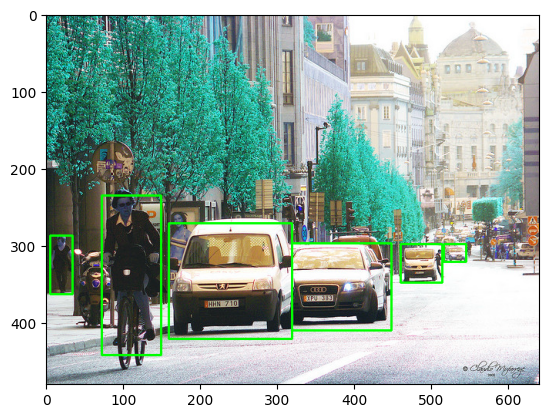

In [37]:
image_copy = image.copy()
for i in range(len(result_box['bboxes__0'])):
    if result_box['scores__2'][i] > 0.6:
        box = result_box['bboxes__0'][i].tolist()
        bbox = list(map(int, box))
        cv2.rectangle(image_copy,(bbox[0],bbox[1]),(bbox[2],bbox[3]),(0,255,0),2)
        print("score : ",result_box['scores__2'][i]*100)
        print("class : ",result_box['classes__1'][i])
    
plt.imshow(image_copy)
plt.show()

score :  95.29474973678589
score :  91.59252047538757
score :  90.95252752304077
score :  90.04114866256714
score :  88.79430294036865
score :  84.54799056053162
score :  72.4134087562561
score :  71.46527171134949
score :  71.37463092803955
score :  70.79163193702698
score :  62.67954707145691


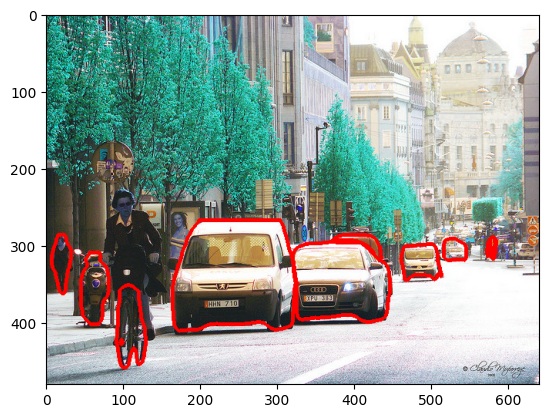

In [38]:
image_copy_seg = image.copy()
for i in range(len(result_seg["MASKS"])):
    if result_seg['SCORES'][i] > 0.6 :
        segment_mask = result_seg["MASKS"][i]
        contours = []
        contour, _ = cv2.findContours(segment_mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        contours.append(contour[0])
        for contour in contours:
            cv2.drawContours(image_copy_seg, [contour], -1, (255,0,0), 3)
        print("score : ",result_seg['SCORES'][i]*100)
    
plt.imshow(image_copy_seg)
plt.show()

# print("score : ",result_seg['SCORES'][0]*100)